# 11 Reprojecting

In this section we will:
- practice merging data frames
- apply `if-else` statements for flow control
- reproject geospatial data 
- create a choropleth map

## About the data

The first dataset we will use is a [list of Arctic communities and their location](https://search.dataone.org/view/doi%3A10.18739%2FA28S4JQ80) @brook_approximate_2023 created by the [Alaska Native Tribal Health Consortium](https://www.anthc.org). This data comess in GeoJSON file with the following attributes:

- **name**: name of Arctic community, 
- **population**: population of Arctic community, as of 2022
- **country**: country that the Arctic community falls within (see dataset metadata for the codes)
- **geoname-id**: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data

The second dataset is [Natural Earth's medium scale  cultural boundaries data for countries (1:50m)](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). 
We can obtain this dataset by downloading the shapefile. 
[Natural Earth](https://www.naturalearthdata.com) is a public domain dataset with ready-to-use data for creating maps. 

## Import data

We will first import the countries shapefile and adapt it for wrangling purposes:

**EXERCISE** 

The following code has 4 bugs, find them and correct them in order to udpate the data.

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import countries shapefile
fp = os.path.join(data_folder_fp, 
                  'ne_50m_admin_0_countries', 
                  'ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names

# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)

# Import country names CSV
fp = os.path.join(data_folder_fp, 
                  'country_names', 
                  'country_names.csv')
country_names = pd.read_csv(fp)

In [8]:
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [9]:
communities.head(3)

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)


In [10]:
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


In [11]:
communities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
countries.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
countries.crs == communities.crs

False

In [14]:
# Reprojecting countries to ensure CRS consistency
countries = countries.to_crs(communities.crs)

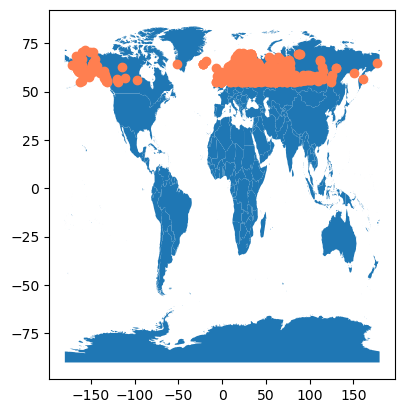

In [16]:
# plot the geospatial data

assert countries.crs == communities.crs

fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color="coral")
plt.show()

In [22]:
# create a dataframe with the number of communities per country
n_comms = (communities.groupby('country').size().reset_index(name='n_communities'))

In [23]:
countries.columns

Index(['admin', 'type', 'geometry'], dtype='object')

In [24]:
n_comms.columns

Index(['country', 'n_communities'], dtype='object')

In [25]:
# Find the intersection between country cols and n comms cols
set(countries.columns).intersection(n_comms.columns)

set()

In [26]:
n_comms = pd.merge(n_comms,
                  country_names,
                  how='left',
                  on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [29]:
# Merge the data frames
arctic_countries = pd.merge(countries, 
                           n_comms,
                           how = 'inner',
                           on = 'admin')
arctic_countries

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
3,Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
4,Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
5,Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
6,Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
7,Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
8,Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98
9,Estonia,Sovereign country,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...",EE,14


In [31]:
# Check Aland Islands is nowhere in countries df
'Aland Islands' in countries.values

False

In [34]:
arctic_countries = arctic_countries.set_index('admin')

In [35]:
arctic_countries

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,99


In [36]:
arctic_countries.at['Finland', 'n_communities'] += 1

<Axes: >

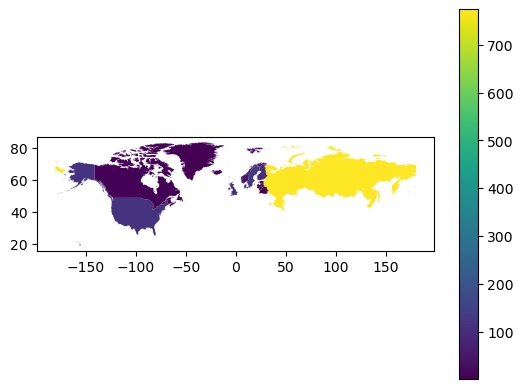

In [38]:
# Choropleth map

arctic_countries.plot(column='n_communities',
                     legend=True)

In [39]:
# Reproject to a CRS that is optimized for the arctic region
arctic_countries = arctic_countries.to_crs('epsg:3413')

<Axes: >

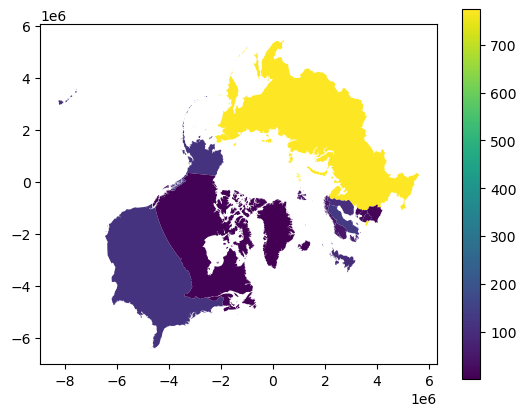

In [40]:
arctic_countries.plot(column='n_communities',
                     legend=True)